The [Laplace transform of a continuous random variable](https://en.wikipedia.org/wiki/Laplace_transform#Probability_theory) $X$ with probability density function (PDF) $f_X$ 
is given by:
    $$\mathcal{L}_X(u)=\operatorname{E}\! \left[e^{-Xu} \right] = \int_0^{\infty} f_X(x)e^{-x\,u}\,dx $$
where $\operatorname{E}$  represents the expectation.

The purpose of this work is to explore the Laplace transform of a [lognormal distributed random variable](https://en.wikipedia.org/wiki/Log-normal_distribution). For the lognormal distributed random variable $X \sim LogN(\mu,v)$ we have $Y=\log(X) \sim N(\mu,v)$, where $\mu$ and $v$ are the expectation and the variance of $\log(X)$ and $N$ denote a normal distribution. So we use second parametrization from https://en.wikipedia.org/wiki/Log-normal_distribution#Alternative_parameterizations . For the $X$ PDF in this parametrization we have: 
$$f_{X}(x,\mu,v)= \frac {1} {\sqrt{2\pi\,v}} \frac{1}{x} \exp\left( -\frac{(\ln x-\mu)^2}{2 v} \right) .$$

Finally
$$\mathcal{L}(u,\mu,v)=\frac {1} {\sqrt{2\pi\,v}} \int_0^{\infty}  \frac{1}{x}\exp(-x\,u) \exp\left(-\frac{(\ln x-\mu)^2}{2 v}\right) dx$$

There is no closed form formula for the above integral. However, we can use direct numerical integration, but first we substitute variables to simplify the calculations. Let's $Y=\ln(X)$ and $x=\exp(y)$

$$\mathcal{L}(u,\mu,v)=\operatorname{E}\! \left[e^{-e^Yu} \right]=\frac {1} {\sqrt{2\pi\,v}} \int_{-\infty}^{\infty} \exp\left(-e^yu-\frac{(y-\mu)^2}{2 v}\right) dy=\frac {1} {\sqrt{2\pi}} \int_{-\infty}^{\infty} \exp\left(-e^{z\sigma+\mu}u-\frac{z^2}{2}\right) dz$$
where $\sigma=\sqrt{v}$, $z=(y-\mu)/\sigma$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.special as scsp
from scipy.special import lambertw
from scipy.integrate import quad
plt.style.use('seaborn-darkgrid')

C:\Users\polzovatel\AppData\Local\Temp\ipykernel_4392\1908021437.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


In [2]:
def LaplTrLNDirect(u,mu,v):
    max_exp=744.0 # np.exp(-max_exp) - minimal double value to calculate without overflow
    def LLN(t): #calculates the Laplace transform for scalar t
        if t==0:
            return np.sqrt(2.0*np.pi*v)
        
        sigma=np.sqrt(v)
        def F(z): #integrand
            s=np.exp(z*sigma+mu)*t+0.5*z**2
            return np.exp(-s)

        lb=-np.sqrt(2.0*max_exp) #low integration bound
        # for smaller values integrand will be calculated as zero
        # anyway due to overflow  
        ub=min((np.log(max_exp/t)-mu)/sigma,-lb) #upper integration bound
        # for bigger values integrand will be calculated as zero
        # anyway due to overflow
        if lb>=ub:
            return 0.0
        return quad(F,lb,ub,epsabs=1.0e-9, epsrel=1.0e-9)[0] #integration
    m=1.0/np.sqrt(2.0*np.pi)
    return m*np.vectorize(LLN,otypes=[float])(u)


We can make it faster. Let's make one more substitution in the last integral $z=\sqrt{2}\sinh(\pi/2\sinh(t))$.
As a result, for the same presition, we can use fewer evently spaced integration points. For more detailed explanation see:

Takahasi, H. and Mori, M. (1974). Double exponential formulas for numerical integration. Publ. RIMS Kyoto Univ, 9:721-741.


In [3]:
int_step=5.5/512.0
t_nodes=np.arange(-150.5*int_step,151.5*int_step,int_step)[:,None]
sinh_t=0.5*np.pi*np.sinh(t_nodes)
sinhsinh_t=np.sinh(sinh_t)
sinhsinh_t2=sinhsinh_t**2
dt_mult=0.5*np.pi*(int_step/np.sqrt(np.pi))*np.cosh(sinh_t)*np.cosh(t_nodes)
max_exp=int(np.finfo(np.float64).maxexp*np.log(2.))            

def LaplTrLNFastD(u,mu,v):
    '''
    fast version of direct integration
    '''
        #np.exp(max_exp) - maximal double value to calculate without overflow
    u=np.atleast_1d(u)[None,:]
    exp_arg=np.sqrt(2.0*v)*sinhsinh_t+mu
    #s=np.exp(np.where(exp_arg<max_exp,exp_arg,max_exp))*u+sinhsinh_t2
    s=np.exp(exp_arg)*u+sinhsinh_t2
    res=np.sum(np.exp(-s)*dt_mult,axis=0)
    if len(res)==1:return res[0]
    return res

In [4]:
LaplTrLNDirect(1,0,1)-LaplTrLNFastD(1,0,1)

0.0

Also we can do following trick:
$$\mathcal{L}(u,\mu,v)=\frac {1} {\sqrt{2\pi}} \int_{-\infty}^{\infty} \exp\left(-e^{z\sigma+\mu}u-\frac{z^2}{2}\right)= dz=\frac {1} {\sqrt{2\pi}} \int_{-\infty}^{\infty} \exp\left(-e^{z\sigma}(e^{\mu}u)-\frac{z^2}{2}\right)=\mathcal{L}(e^{\mu}u,0,v).$$
So it is suffiecient to consider only the case where $\mu=0$, and we will explore the function $\mathcal{L}_v(u)=\mathcal{L}(u,0,v)$.

In [5]:
def LaplTrLNFastD(u,v):
    '''
    fast version of direct integration
    '''
    s=np.exp(np.sqrt(2.0*v)*sinhsinh_t)*np.atleast_1d(u)[None,:]+sinhsinh_t2
    res=np.sum(np.exp(-s)*dt_mult,axis=0)
    if len(res)==1:return res[0]
    return res

In [6]:
u=np.array([0.1,2,10])
mu,v=1,1
LaplTrLNDirect(u,mu,v)-LaplTrLNFastD(u*np.exp(mu),v)

array([-3.33066907e-16, -4.16333634e-17,  4.33680869e-19])

Our goal is to get some method to approximate the Laplace transform of the lognormal distribution. In the literature there are several attempt based on series expansion, but all of them computationally expensive.

In
[S. Asmussen, J.L. Jensen, L. Rojas-Nandayapa (2016). "On the Laplace transform of the Lognormal distribution", Methodology and Computing in Applied Probability 18 (2), 441-458](https://link.springer.com/article/10.1007/s11009-014-9430-7)
there is fast approximation 

$$\mathcal{L}^*_v(u)=\frac{\exp\left(-\frac{W(\theta)(W(\theta)+ 2)}{2v} \right)}{\sqrt{1+W(\theta)}}$$
where
$$\theta=uv$$

and $W$ is the Lambert W function.

In [7]:
def LaplTrLNApprox(u,v):
    theta=u*v
    W=np.real(scsp.lambertw(theta))
    return np.exp(-W*(W+2)/(2*v))/np.sqrt(1+W)


We propose a novel method based on constructing ODE (odinary differntial equasions) sets whose solutions approximate $\mathcal{L}_v(u)$.The idea of the method appeared while exploring a disease spread in a non-homogeneous population. In the most simple form, where only two types of population susceptible ($S$) and infectious ($I$) exist, the disease transmission is given by equation:
$$
\begin{align}
& \frac{dS}{dt} = - a I S, \\[3pt]
&I = 1-S,\\[3pt]
&S(0)=S_0
\end{align}
$$
here

$a$ - Some constant

$S$ - The proportion of the of susceptible population

$I$ - The proportion of the of infectious population

and the equation means that overall attack rate is proportional to the product of susceptible and infectious population.

Let's add heterohenity of catching the deseise. Let $s(c,t)$ denotes the portion (at moment t) of susceptible population with (nonnegative) ability to catch the disease $c$. At the beginning it is equal to one ($s(c,0)=1$) and moves down to zero in time as more and more individuals get infected. The total portion of susceptible population obtained by integrating over the distribution of c:
$$\begin{equation}
S(t)=\int_0^{\infty} s(c,t)f_C(c)dx  \tag{1}
\end{equation}
$$

Now consider the part of $s(c,t)$ that becomes infectious at the interval $t,t+dt$. This part is proportional to $s(c,t)$ itself, ability to catch the disease $c$, and total portion of infectious population. Assuming proportionality coeffitient equal to 1 we have:
$$ds(c,t)=-c\,s(c,t)I(t)dt=-c\,s(c,t)(1-S(t))dt$$

To continue we need some crazy deseise for which the equation above looks different:

$$ds(c,t)=-c\,s(c,t)S(t)dt  \tag{2}$$

Or we can just start our explanation from this equation. Combining (1) and (2) we get
$$\frac{ds}{dt}=-c\,s\,\int_0^{\infty} s(c,t)f_C(c)\,dc$$


Let $s(c,t)=e^{-c\,u(t)}$ then we have
$$-c\,s\,\frac{du(t)}{dt}=-c\,s\,S(t)=-c\,s\,\int_0^{\infty} e^{-c\,u(t)}f_C(c)\,dx$$
or
$$\frac{du}{dt}=S(t)=\int_0^{\infty} f_C(c)e^{-c\,u(t)}\,dx=\mathcal{L}_C(u(t))$$

If we take $C \sim LogN(\mu_0,v_0)$ we will have
$$\frac{du}{dt}=S(t)=\mathcal{L}(u(t),\mu_0,v_0) \tag{3}$$
$$u(0)=0,\,S(0)=1$$

We can think of the situation the other way around, and it gives us an approximate solution for equation (3).

In our previous model, we utilized a lognormally distributed variable, denoted as $C$, to characterize the collective ability of **the entire population** to contract the disease. The distribution was constant, with all dynamics encapsulated by $s(c, t)$—representing the proportion of the susceptible population with the ability to contract and propagate the disease denoted by $c$. Presently, we employ a lognormally distributed variable, denoted as $X(t)$, to model the ability of **the susceptible population** specifically to contract the disease. Additionally, we need the variable $S(t)$, denoting as previous, the proportion of the susceptible population relative to the entire population.

Let us consider a moment in time, $t$, where the lognormal distribution of $X$ has parameters $\mu(t)=E[\log(X(t))]$ and $v(t)=Var[\log(X(t))]$. We aim to compute the new values $\mu(t+dt)=E[\log(X(t+dt))]$ and $v(t+dt)=Var[\log(X(t+dt))]$ at the time $t+dt$. Although the distribution at $t+dt$ will deviate from lognormality, we assume that it adjusts itself to become lognormal with the new parameters $\mu(t+dt)$ and $v(t+dt)$.

Let $s'(x,t)$ represent the "density" of the susceptible population (susceptible portion of the total population with the ability to contract and propagate the disease in the interval $[x,x+dx]$ is $s'(x,t)dx$). This density is given by the expression:

$$ s'(x,t) =   f_{X}(x,t)S(t) $$

Here, $f_{X}(x,t)\sim LogN(\mu(t), v(t))$ is the probability density function of $X$ at time $t$.


and we have analog of (2)
$$ds'(x,t)=-x\, s'(x,t)\, S(t)dt=-x\, f_{X}(x)\, S^2(t)dt$$

It is much more simple to deal with normal distribution then lognormal. That's why we make substitution $Y=\ln(X)$ (so $X=e^Y$) and mostly use $Y$ later.

In $Y$ terms we have
$$ s(y,t) =   f_{Y}(y,t)S(t) $$
Vice versa 
$$f_{Y}(y,t)=\frac{s(y,t)}{S(t)}\tag{4}$$

Here, $f_{Y}(y,t)\sim N(\mu(t), v(t))$.


$$ds(y,t)=-e^y\, s(y,t)\, S(t)dt=-e^y\, f_{Y}(y)\, S^2(t)dt$$




We start from calculation $s(t+dt)$. 

$$s(y,t+dt)=s(y,t)+ds(y,t)=s(y,t)-e^y\, s(y,t)\, S(t)dt=f_{Y}(y,t)(S-e^y\,S^2\, dt)\tag{5}$$

integrating it over x we get
$$S(t+dt)= \int_{-\infty}^{\infty}f_{Y}(y,t)(S(t)-e^y\,S(t)^2\, dt)\,dxy=(S-E[e^Y(t)]S^2 \,dt)=S- M S^2\,dt\tag{6}$$
or
$$\frac{dS}{dt}=- M S^2$$

where $M$ (same as ${}^0\!M$ later) is the function of $t$ : $$M(t) =E[e^{Y(t)}]=\exp\left(\mu(t)+\frac{v(t)}{2}\right)$$ as for $Y\sim N(\mu,v)$, where $v$ is variance, $E[e^Y(t)]=\exp(\mu+\frac{v}{2})$.

Combinimg (4),(5), and (6)

$$f_{Y}(t+dt)=\frac{s(y,t+dt)}{S(t+dt)}=f_{Y}(y,t)\frac{1-e^y S\, dt}{1- M S\, dt}$$

Up to first order on $dt$ terms 

$$f_{Y}(t+dt)=f_{Y}(t)(1+(M-e^y)Sdt)+o(dt)\tag{7}$$

so

$$\mu(t+dt)=E\,[Y(t+dt)]=\int_{-\infty}^{\infty}f_{Y}(y,t+dt)y\,dy=\int_{-\infty}^{\infty}f_{Y}(y,t)(1+(M-e^y)Sdt)y\,dy +o(dt)$$
$$=E\left[(1+(M - e^{Y(t)}) S\,dt)Y(t)\right]+o(dt)=E[Y](1+MSdt) - E[Ye^Y]S\,dt+o(dt)\tag{8}$$

Later we need to calculate the expectations $ E[Y^ie^{Y}]$
for some integer i and random variable $Y$, which we denote ${}^i\!M_{Y}$ or just ${}^i\!M$ (${}^0\!M$ we denote as $M$). We can use following property:

$${}^i\!M_{Y} = E[Y^ie^{Y}]=\frac{d^iE[e^{zY}]}{dz^i} \biggr | _1=\frac{d^i\mathcal{M}_Y(z)}{dz^i} \biggr | _1$$
where $\mathcal{M}_Y(z):=E[e^{zY}]$ is the [Moment-generating function](https://en.wikipedia.org/wiki/Moment-generating_function) (MGF) of Y.

From MGF properties we can find moments $m_i$ of $Y$ as follows
$$m_i=E[Y^i]=\frac{d^i\mathcal{M}_Y(z)}{dz^i} \biggr | _0$$

In these notations we rewrite (8):
$$\mu(t+dt)=m_1(t+dt)=m_1(t)\left(1+M(t)S(t)dt\right) - {}^1\!M(t)S(t)\,dt+o(dt)=m_1(t)+\left(M(t)m_1(t)-{}^1\!M(t)\right)S(t)dt+o(dt)$$

or 
$$d\mu=dm_1=\left(M(t)m_1(t)-{}^1\!M(t)\right)S(t)dt$$

The same way, it is possible to find expression for differential of any raw momentum of $Y$

$$dm_i=m_i(t+dt)-m_i(t)=E\left[\left(1+(M - e^{Y(t)}\right) S\,dt){Y(t)}^i\right]-m_i(t)=\left(M(t)m_i(t)-{}^i\!M(t)\right)S(t)dt\tag(9)$$



For the normally distributed $Y \sim N(\mu,v)$ MGM is
$$\mathcal{M}_Y(z)=\exp(\mu z+\frac{vz^2}{2})$$

Finally
$$\mu(t+dt)=\mu(t)-M(t) S(t) v(t)\,dt +o(dt)$$
also omitting some math

$$v(t+dt)=v(t)-M(t) S(t) v^2(t)\,dt +o(dt) $$

As a result, we have the system:
$$M=e^{\mu+v/2}$$
$$\frac{dS}{dt}=-M S^2$$
$$\frac{d\mu}{dt}=-M S v \tag{4}$$
$$\frac{dv}{dt}=-M S v^2$$
$$S(0)=1,\,\mu(0)=\mu_0,\,v(0)=v_0$$

The system has been constructed a way to be close to solution (3). So if $S(t)$ is the solution of (4) we can write:
$$\frac{du}{dt}=\mathcal{L}(u(t),\mu_0,v_0) \approx S(t). \tag{5}$$

The problem is we have approximate solution depending on $t$, not $u$. To solve this we rewrite (4)


$$\frac{dS}{du}=-M S^2\frac{dt}{du},$$

$$\frac{d\mu}{du}=-M S v \frac{dt}{du},\tag{6}$$

$$\frac{dv}{du}=-M S v^2\frac{dt}{du},$$

$$S(0)=1,\,\mu(0)=\mu_0,\,v(0)=v_0$$

and from (5) we know
$$ \frac{dt}{du} \approx \frac{1}{S}$$

The idea to substitute this to (6) - it is approximate system anyway, so pretending that 
$$ \frac{dt}{du} = \frac{1}{S}\tag{8}$$
makes approximation little worse. 

Now we get
$$\frac{dS}{du}=-M S,$$

$$\frac{d\mu}{du}=-M v,\tag{6}$$

$$\frac{dv}{du}=-M v^2,$$

$$S(0)=1,\,\mu(0)=\mu_0,\,v(0)=v_0$$

$S(u)$ should be close to $\mathcal{L}(u,\mu_0,v_0)$. Let $L=\ln(S)$ and remember we considering the case $\mu_0=0$ then for $L$ system (6) looks:

$$M=e^{\mu+v/2}$$

$$\frac{dL}{du}=-M,$$

$$\frac{d\mu}{du}=-M v,\tag{10}$$

$$\frac{dv}{du}=-M v^2,$$

$$L(0)=1,\,\mu(0)=0,\,v(0)=v_0$$

$$S=e^L$$



In [8]:
from scipy.integrate import odeint,solve_ivp

In [47]:
def LaplTrLNODE1(u,v0):# u must start from 0
    def ode(y,t):
        _,mu,v=y
        dL=-np.exp(mu+0.5*v)
        dmu=dL*v
        dv=dmu*v
        return [dL,dmu,dv]
    L,_,_=odeint(ode,[0.0,0.0,v0],u).T
    S=np.exp(L)
    return S

It is possible to reduce the system to one equation. Let $V=1/v$ then
$$\frac{dV}{du}=M$$
We have
$$\frac{d\mu}{dV}=\frac{d\mu}{du}\frac{du}{dV}=-v=-\frac{1}{V}$$
so 
$$\mu=C-\ln(V)$$
The value of the constant C is given by condition $\mu(0)=0$ hence
$$C=\ln(V_0)=-\ln(v_0)$$
and
$$\frac{dV}{du}=\exp(\ln(V_0)-\ln(V)+0.5/V)=\frac{V_0}{V}\exp(\frac{1}{2 V})$$
$$L=V0-V$$
Finally

$$V(0)=\frac{1}{v_0}$$
$$\frac{dV}{du}=\frac{V(0)}{V}\exp(\frac{1}{2 V})$$
$$\mathcal{L}_{v_0}(u) \approx \exp(V0-V(u))$$

In [10]:
def LaplTrLNODE2(u,v0):
    V0=1.0/v0
    def ode(V,t):return V0*np.exp(0.5/V)/V
    y=odeint(ode,V0,u).T
    return np.exp(V0-y[0])

In [11]:
modeling_period=10.0
u_step=0.02
u_r=np.arange(0.0, modeling_period+u_step, u_step,dtype=np.float64)
n_steps=len(u_r)-1

In [12]:
v0=0.75

Cheking the functions give the same result

In [48]:
np.allclose(LaplTrLNODE1(u_r,v0),LaplTrLNODE2(u_r,v0))

True

Here we are

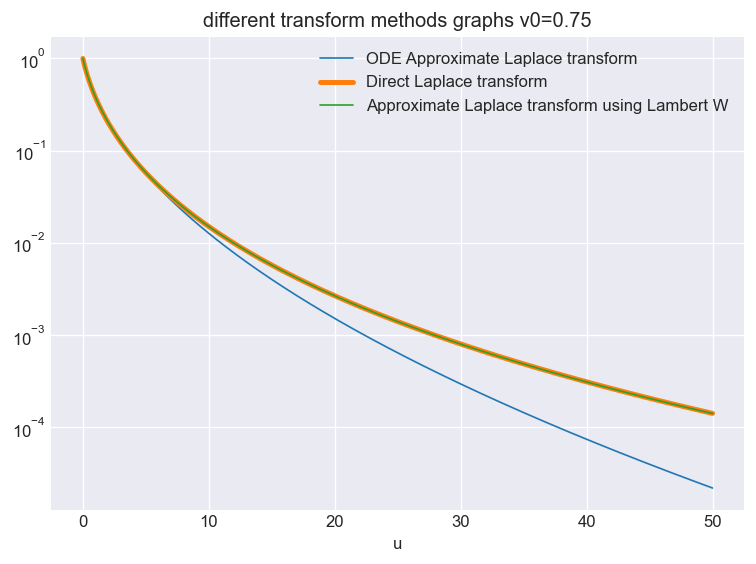

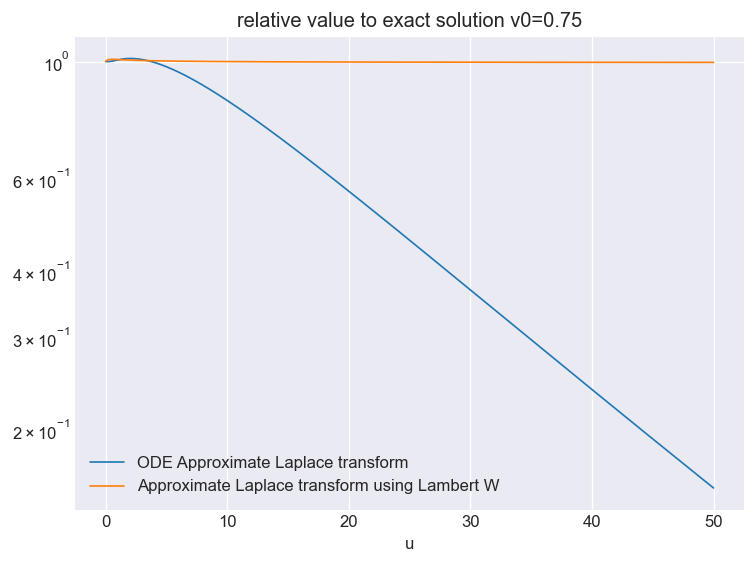

In [111]:
direct=LaplTrLNFastD(u_r,v0)
fig, ax = plt.subplots(dpi=120)
plt.title(f'different transform methods graphs v0={v0}')

plt.plot(u_r,LaplTrLNODE2(u_r,v0),linewidth=1, label=f'ODE Approximate Laplace transform')
plt.plot(u_r,direct, linewidth=3, label=f'Direct Laplace transform')
plt.plot(u_r,LaplTrLNApprox(u_r,v0),linewidth=1, label=f'Approximate Laplace transform using Lambert W')

plt.xlabel('u')
plt.yscale('log')
plt.legend(loc='upper right')
fig.tight_layout()
plt.show()

fig, ax = plt.subplots(dpi=120)
plt.title(f'relative value to exact solution v0={v0}')
plt.plot(u_r,LaplTrLNODE2(u_r,v0)/direct,linewidth=1, label=f'ODE Approximate Laplace transform')
plt.plot(u_r,LaplTrLNApprox(u_r,v0)/direct,linewidth=1, label=f'Approximate Laplace transform using Lambert W')

plt.xlabel('u')
plt.legend(loc='lower left')
fig.tight_layout()
plt.show()

Up to $u=1$, the ODE approximation of the $\mathcal{L}_{v_0}(u)$ is quite good but rapidly becomes inaccurate for $u>1$. Can we improve it?

The inaccuracy originates from the imperfection of the normal distribution's approximation of the distribution $f_{Y}(t+dt)$. Better fitting requires the use of a distribution with more parameters $Y'\left(p_1(t),p_2(t),p_3(t),...,p_n(t)\right)$ in order to produce better proximity to $f_{Y}(t+dt)$. Also the distribution needs to be normal at $t=0$.
$$Y'(p_1(0),p_2(0),p_3(0)...,p_n(0)) \sim N(\mu_0,v_0)$$

Normal distribution has two parameters. Let's take some known distribution with three parameters and see what happens, for example [skew normal distribution](https://en.wikipedia.org/wiki/Skew_normal_distribution). Yet we need cumbersome math calculations to get work done. To move forward, it needs to automate the calculations.

We already have equations for differential of any raw moment of $Y$ (9) but we rewrite it for $du$
$$dm_i=\left(M(t)m_i(t)-{}^i\!M(t)\right)S(t)dt=\left(M(t)m_i(t)-{}^i\!M(t)\right)S(t)\frac{dt}{du}du$$
$$ =\left(M(t)m_i(t)-{}^i\!M(t)\right)du$$
we use  (8) $S\frac{dt}{du}=1$.

Sometimes it is usefull to have equations for central moment. By the defenition
$$c_i=E[(Y-m_1)^i]=\sum_{k=0}^n(-1)^k{n \choose k}E[Y^{i-k}]m_1^k=\sum_{k=0}^n(-1)^k{n \choose k}m_{i-k}m_1^k.$$

We need to find $dc_i$.
$$c_i(u+du)=\sum_{k=0}^n(-1)^k{n \choose k}(m_{i-k}+dm_{i-k})(m_1+dm_1)^k$$
To find $dc_i$ it is sufficient to expand the last expression and find find the coefficient for $du$

In [14]:
import sympy as sp
sp.init_printing()
μ,ξ,w,d,k,t,x,y,p,m,v,q,r,s,z = sp.symbols('μ,ξ,w,d,k,t,x,y,p,m,v,q,r,s,z')
normalMGF=sp.exp(z*μ + z**2*v/2)

In [15]:
print('MGF for normal distribution is')
normalMGF

MGF for normal distribution is


In [16]:
def RM(MGM,i): 
    '''
    symbolic function returns i-th (start from 1) raw moment: E[Y^n]
    MGM(z) - Moment-generating function
    '''
    return sp.diff(MGM,z,i).subs(z,0)

In [17]:
print('first and second raw moment for normal distribution is')
[RM(normalMGF,1),RM(normalMGF,2)]

first and second raw moment for normal distribution is


In [18]:
def RMgenerator(MGF): 
    '''
    returns symbolic function returning i-th (start from 1) 
        raw moment: E[Y^n]
    MGF(z) - Moment-generating function
    '''
    return lambda i:sp.diff(MGF,z,i).subs(z,0)

In [19]:
normal_rm=RMgenerator(normalMGF)
print('second and third raw moment for normal distribution is')
[normal_rm(2),normal_rm(3)]

second and third raw moment for normal distribution is


In [20]:
def CM(rm,i): 
    '''
    symbolic function returns i-th (start from 1) central moment: E[(Y-E[Y])^n]
    if i==1 returns 1st raw moment (1st central moment always 0) 
    rm - raw moment generator
    '''
    if i==1: return rm(1)
    x = sp.symbols('u_s')
    expr=sp.expand((x-rm(1))**i)
    for n in range(i,0,-1):
        expr=expr.subs(x**n,rm(n))
    return sp.simplify(expr)

In [21]:
print('second and third central moment for normal distribution is')
[CM(normal_rm,2),CM(normal_rm,3)]

second and third central moment for normal distribution is


In [22]:
def CMgenerator(MGF): 
    return lambda i:CM(RMgenerator(MGF),i)

In [23]:
normal_cm=CMgenerator(normalMGF)
print('third and fourth central moment for normal distribution is')
[normal_cm(3),normal_cm(4)]

third and fourth central moment for normal distribution is


Functions bellow calculates
${}^i\!M_{Y}$

In [24]:
def EM(MGF,i): 
    '''
    symbolic function returns i-th (start from 1) exp moment: E[e^Y*Y^i]
    '''
    return sp.diff(MGF,z,i).subs(z,1)

def EMgenerator(MGF): 
    return lambda i:EM(MGF,i)

${}^0\!M$ and ${}^1\!M$ for normal distribution is

In [25]:
[EM(normalMGF,0),EM(normalMGF,1)]

${}^1\!M$ and ${}^2\!M$ for normal distribution is

In [27]:
normal_em=EMgenerator(normalMGF)
[normal_em(1),normal_em(2)]

Now its time for $dm_i/du$.

In [29]:
def DRM(MGF,i):
    '''
    symbolic function returns differential of i-th (start from 1) raw moment
     '''
    if i==0:
        return -EM(MGF,0)
    return sp.simplify(RM(MGF,i)*EM(MGF,0)-EM(MGF,i))

def DRMgenerator(MGF):
    return lambda i:DRM(MGF,i)

$\frac{dm_1}{du}$ and $\frac{dm_2}{du}$ for normal distribution is

In [30]:
[DRM(normalMGF,1),DRM(normalMGF,2)]

As mentioned above to get $dc_i/du$ we need the series for $dm_i(U+dU)$ first

In [32]:
dU=sp.symbols('dU')
def RMSeries(MGF,i):
    '''
    series dm_i(U+dU) up to first term 
    '''
    return sp.expand(RM(MGF,i)+DRM(MGF,i)*dU)

def RMSgenerator(MGF):# series dS(t) up to first term 
    return lambda i:RMSeries(MGF,i)

raw moments $m_1(U+dU)$ and $m_2(U+dU)$  for normal distribution is

In [33]:
[RMSeries(normalMGF,1),RMSeries(normalMGF,2)]

Next, we can get $dc_i(U+dU)$ by using CM function

central moments $c_2(U+dU)$ and $c_3(U+dU)$  for normal distribution is

In [35]:
[CM(RMSgenerator(normalMGF),2),CM(RMSgenerator(normalMGF),3)]

Finally the function to find $dc_i/du$

In [58]:
def DCM(MGF,i):
    if i==0:
        return -EM(MGF,0)    
    expr=CM(RMSgenerator(MGF),i)
    return sp.simplify(sp.diff(expr,dU,1).subs(dU,0))

def DCMgenerator(MGF):
    return lambda i:DCM(func,i)

In [38]:
print('The right side for the normal distribution is')
sp.Matrix([DCM(normalMGF,0),DCM(normalMGF,1),DCM(normalMGF,2)])

The right side for the normal distribution is


⎡   v      ⎤
⎢   ─ + μ  ⎥
⎢   2      ⎥
⎢ -ℯ       ⎥
⎢          ⎥
⎢    v     ⎥
⎢    ─ + μ ⎥
⎢    2     ⎥
⎢-v⋅ℯ      ⎥
⎢          ⎥
⎢     v    ⎥
⎢     ─ + μ⎥
⎢  2  2    ⎥
⎣-v ⋅ℯ     ⎦

So for the normal distribution we get exacltly (10) as expected. For the normal distribution it is convinient to use second central moment dynamics. Still there is a possibility to make approximate equations using raw moments only. In this case we need to infer parameters $\nu,v$ from the moments first.

Once again

In [39]:
print('first and second raw moment for normal distribution is')
[RM(normalMGF,1),RM(normalMGF,2)]

first and second raw moment for normal distribution is


It follows: $\mu=m_1$ and $v=m_2-m_1^2$. The moments dynamic is given by right side:

In [40]:
sp.Matrix([DRM(normalMGF,0),DRM(normalMGF,1),DRM(normalMGF,2)])

⎡         v            ⎤
⎢         ─ + μ        ⎥
⎢         2            ⎥
⎢       -ℯ             ⎥
⎢                      ⎥
⎢          v           ⎥
⎢          ─ + μ       ⎥
⎢          2           ⎥
⎢      -v⋅ℯ            ⎥
⎢                      ⎥
⎢                 v    ⎥
⎢                 ─ + μ⎥
⎢⎛ 2          2⎞  2    ⎥
⎣⎝μ  - (v + μ) ⎠⋅ℯ     ⎦

And the function to approximate the Laplace transform of the lognormal distribution $\mathcal{L}_{v_0}(u)$ is 

In [50]:
def LaplTrLNODE3(u,v0):# u must start from 0
    def ode(y,t):
        _,mu,m2=y
        v=m2-mu**2
        dL=-np.exp(mu+0.5*v)
        dmu=v*dL
        dm2=(v+2*mu)*dmu #-(v^2+2vmu+mu^2-mu^2)M
        return [dL,dmu,dm2]
    L,_,_=odeint(ode,[0.0,0.0,v0],u).T
    S=np.exp(L)
    return S

In [51]:
np.allclose(LaplTrLNODE1(u_r,v0),LaplTrLNODE3(u_r,v0))

True

In common, we get parameters from moments and moments derivatives from parameters.

Now we are ready for [skew normal distribution](https://en.wikipedia.org/wiki/Skew_normal_distribution). First of all we need a paramerization convinient for our purposes. Instead of using

$\xi$ location, real

$\omega$ scale, positive

$\alpha$ shape parameter, real

we  use anoter parametrization $\xi,w,d$ 
$$ w=\omega^2,\,\, d=\sqrt{\frac{2}{\pi}}\omega\delta,$$
where
$$\delta^2=\frac{\alpha^2}{1+\alpha^2}$$
It follows that $\delta$ can't exceed 1.
Given $w,d$ we can get $\omega,\delta,\alpha$:
$$\omega=\sqrt{w},\,\, \delta=\sqrt{\frac{\pi}{2w}}d,\,\,\alpha=\frac{\delta}{\sqrt{1-\delta^2}}$$

The MGF of the skew normal distributed variable Y is:
$$\mathcal{M}_Y(z)=\exp(z\xi+ \frac{z^2w}{2})(1+\operatorname{erf}(\frac{\sqrt{\pi}}{2}zd))$$

In [66]:
snormalMGF=sp.exp(z*ξ + z**2*w/2)*(1+sp.erf(sp.sqrt(sp.pi)*z*d/2))
snormalMGF

For skew normal distribution $m_1$, $c_2$ and $c_3$ is

In [67]:
snormal_rm=RMgenerator(snormalMGF)
[snormal_rm(1),CM(snormal_rm,2),CM(snormal_rm,3)]

Given  $m_1$, $c_2$ and $c_3$ we can find parameters
$$d=\sqrt[3]{\frac{2c_3}{4-\pi}}$$
$$w=c_2+d^2$$
$$\xi=m_1-d$$

#### First,  $dm_1/du$ is

In [79]:
dm1=DRM(snormalMGF,1)
display(dm1)
print('latex:',sp.latex(dm1))
#print('python:',dm1)


latex: \left(- d + \left(d - w\right) \left(\operatorname{erf}{\left(\frac{\sqrt{\pi} d}{2} \right)} + 1\right) e^{\frac{\pi d^{2}}{4}}\right) e^{- \frac{\pi d^{2}}{4} + \frac{w}{2} + ξ}


After some rewriting
$$\frac{dm_1}{du}=e^{\xi +\frac{w}{2}} \left((1+\operatorname{erf}\left(\frac{\sqrt{\pi } d}{2}\right)) (d-w)-d
   e^{-\frac{\pi  d^2}{4}}\right)$$
   
#### Second,$dc_2/du$ is   

In [83]:
dc2=DCM(snormalMGF,2)
display(dc2)
#print('latex:',sp.latex(dc2))
#print('python:',dc2)

It can be expressed in more simple form (thanks Mathematica):

$$\frac{dc_2}{du}=\frac{1}{2} e^{\xi +\frac{w}{2}}\left( d e^{-\frac{\pi  d^2}{4}} \left(\pi  d^2+4 d-4 w\right)-2
   \operatorname{erfc}\left(-\frac{\sqrt{\pi } d}{2}\right) \left(2 d^2-2 d w+w^2\right)\right)$$
where $\operatorname{erfc}(-x)=1+\operatorname{erf}(x)$

#### And finally, $dc_3/du$

In [84]:
dc3=DCM(snormalMGF,3)
display(dc3)

Once again Mathematica is used to simplify
$$\frac{dc_2}{du}=-\frac{1}{4}e^{\xi +\frac{w}{2}} \left(2 \text{erfc}\left(-\frac{\sqrt{\pi } d}{2}\right)
   \left((\pi -12) d^3+12 d^2 w-6 d w^2+2 w^3\right)+d e^{-\frac{\pi  d^2}{4}}\left(\pi ^2 d^4+6 \pi  d^3-2 d^2 (3 \pi 
   w+\pi -12)-24 d w+12 w^2\right)\right)$$
   
Now we have all components and function to approximate the Laplace transform of lognormal variable is

In [126]:
def LaplTrLNODESkewNormal(u,v0):# u must start from 0
    const1=1.0/(2.0-np.pi/2.0)
    def ode(y,t):
        
        _,N,V,C=y
        
        d=np.cbrt(const1*C)
        dsq=d**2
        
        w=V+dsq
        wsq=w*w
        
        ξ=N-d
        
        M=np.exp(0.5*w + ξ)
        E=d*np.exp(-0.25*dsq*np.pi)
        A=1.0+scsp.erf(0.5*d*np.sqrt(np.pi)) #scsp.erfc(-0.5*d*np.sqrt(np.pi))
        
        dL=-M*A
 
        dN=M*((d-w)*A-E)
        
        dV=0.5*M*(E*(4*d+dsq*np.pi-4*w)-2*(2*dsq-2*d*w+wsq)*A)
        
        S1=dsq*(12*w  + (np.pi - 12)*d) + (2*w-6*d)*wsq
        S2=dsq*np.pi*(6*d + dsq*np.pi) - 24*d*w + 12*wsq - 2*dsq*(np.pi + 3*np.pi*w - 12)
        dC=-0.25*M*(2*A*S1+E*S2)
        return [dL,dN,dV,dC]
    L,_,_,_=odeint(ode,[0.0,0.0,v0,0.0],u).T
    S=np.exp(L)
    return S

Let's look at the results

In [127]:
modeling_period=20.0
u_step=0.02
u_r=np.arange(0.0, modeling_period+u_step, u_step,dtype=np.float64)
n_steps=len(u_r)-1

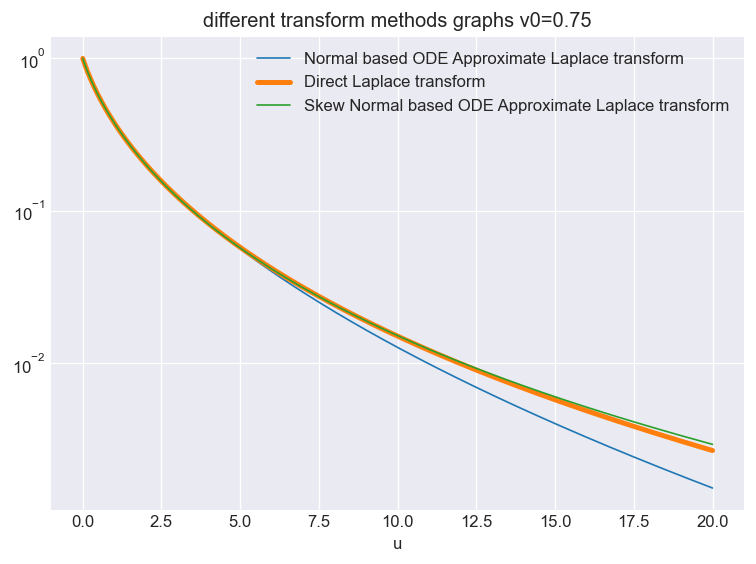

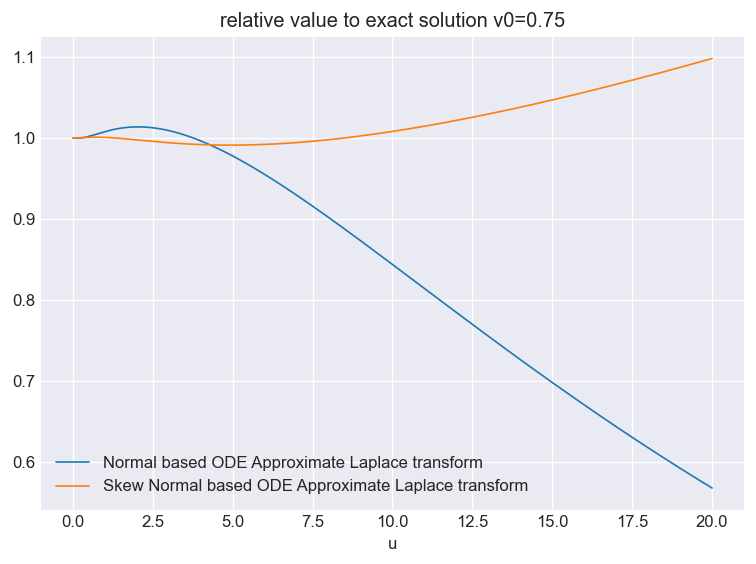

In [128]:
direct=LaplTrLNFastD(u_r,v0)
skew_normal=LaplTrLNODESkewNormal(u_r,v0)
fig, ax = plt.subplots(dpi=120)
plt.title(f'different transform methods graphs v0={v0}')

plt.plot(u_r,LaplTrLNODE2(u_r,v0),linewidth=1, label=f'Normal based ODE Approximate Laplace transform ')
plt.plot(u_r,direct, linewidth=3, label=f'Direct Laplace transform')
plt.plot(u_r,skew_normal,linewidth=1, label=f'Skew Normal based ODE Approximate Laplace transform')

plt.xlabel('u')
plt.yscale('log')
plt.legend(loc='upper right')
fig.tight_layout()
plt.show()

fig, ax = plt.subplots(dpi=120)
plt.title(f'relative value to exact solution v0={v0}')
plt.plot(u_r,LaplTrLNODE2(u_r,v0)/direct,linewidth=1, label=f'Normal based ODE Approximate Laplace transform')
plt.plot(u_r,skew_normal/direct,linewidth=1, label=f'Skew Normal based ODE Approximate Laplace transform')

plt.xlabel('u')
plt.legend(loc='lower left')
fig.tight_layout()
plt.show()


Indeed approximation become better.